In [1]:
# %load /home/dan/.jupyter/firstcell.py
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import numpy as np
import pandas as pd

In [2]:
import phate, magic, meld
import pandas as pd
import dbio, os
import scprep
import graphtools as gt

font = {'size'   : 14}
mpl.rc('font', **font)


fig_dir = '../figs/runs_combined.pre_and_post'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

In [41]:

font = {'size'   : 14}
mpl.rc('font', **font)

In [3]:
run2_data_asin = pd.read_pickle('/home/dan/data/burkhardt/sbrt_trial/run2.pre_and_post.data.pkl')
run2_metadata = pd.read_pickle('/home/dan/data/burkhardt/sbrt_trial/run2.pre_and_post.metadata.pkl')
labels = ['CD45', 'CD196', 'T-bet', 'CD127', 'CD69', 'CD4', 'CD8a', 'CD7',
          'CD200R', 'CD25', 'CD38', 'CD278', 'TNFa', 'Tim-3', 'CD185',
          'CD36', 'CD95', 'CD137', 'CD197', 'CD28', 'CD152', 'FoxP3', 'CXCR3',
          'CD45RO', 'IFNg', 'LAG-3', 'GzmB', 'Ki-67', 'Eomes', 'CD3',
          'CD226', 'CD274', 'TIGIT', 'TCF7', 'PD-1', 'IL-10', 'CD11b']

run2_data_asin.columns = pd.Index(labels)

In [4]:
run1_data_asin = pd.read_pickle('/home/dan/data/burkhardt/sbrt_trial/run1.pre_and_post.data.pkl')
run1_metadata = pd.read_pickle('/home/dan/data/burkhardt/sbrt_trial/run1.pre_and_post.metadata.pkl')

#fix metadata
run1_metadata_updated  = run1_metadata.reset_index()
run1_metadata_updated.columns = pd.Index(['sample', 'filename', 'sample_id', 'date', 'stimulated', 'pre_post_sbrt',
       'time_RES', 'response', 'response_RES', 'days_to_progression', 'run',
       'progression_RES'])
run1_metadata_updated.index = pd.Index(['_'.join([str(i), s]) for i,s in zip(run1_data_asin.index, run1_metadata_updated['sample'])])
run1_metadata = run1_metadata_updated

run1_data_asin.index = pd.Index(['_'.join([str(i), s]) for i,s in zip(run1_data_asin.index, run1_metadata_updated['sample'])])


labels = ['CD45', 'CD196', 'T-bet', 'CD127', 'CD69', 'CD4', 'CD8a', 'CD7',
       'CD200R', 'CD25', 'CD38', 'CD278', 'TNFa', 'CD185', 'CD36',
       'CD95', 'CD137', 'CD197', 'CD28', 'CD152', 'FoxP3', 'CXCR3', 'CD45RO',
       'IFNg', 'LAG-3', 'GzmB', 'Ki-67', 'Eomes', 'CD3', 'CD226',
       'CD274', 'TIGIT', 'TCF7', 'PD-1', 'IL-10', 'CD11b']

run1_data_asin.columns = pd.Index(labels)


In [5]:
data = pd.concat([run1_data_asin, run2_data_asin])[run1_data_asin.columns]
metadata = pd.concat([run1_metadata, run2_metadata])

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


In [1]:
G = gt.Graph(data, knn=20)

NameError: name 'gt' is not defined

In [ ]:
phate_op = phate.PHATE(knn_dist='precomputed', n_jobs=12)
data_phate = phate_op.fit_transform(G.K)

In [ ]:
import magic

magic_op = magic.MAGIC(k=G.knn, n_pca = G.n_pca, a=G.decay)
data_magic_run1 = pd.DataFrame(magic_op.fit_transform(run1_data_asin), columns=data.columns)
magic_op = magic.MAGIC(k=G.knn, n_pca = G.n_pca, a=G.decay)
data_magic_run2 = pd.DataFrame(magic_op.fit_transform(run2_data_asin), columns=data.columns)

data_magic =  pd.concat([data_magic_run1, data_magic_run2])

In [175]:
clusters = phate.cluster.kmeans(phate_op, k=20)

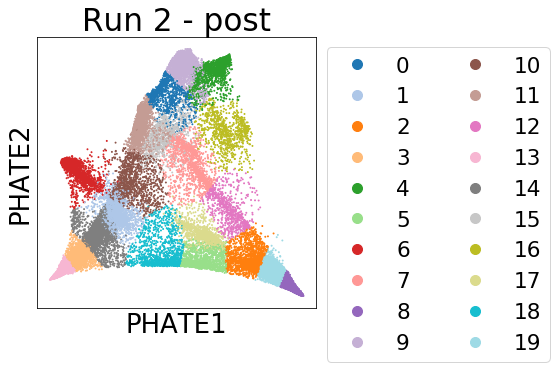

In [180]:
scprep.plot.scatter2d(data_phate, c=clusters, cmap='tab20', 
                     title=title, ticks=False, label_prefix='PHATE', legend_anchor=(1,1), figsize=(5,5))

In [59]:
new_clusters = np.zeros(data.shape[0], int)


new_clusters[clusters == 5] = 0
new_clusters[clusters == 0] = 1
new_clusters[clusters == 3] = 2
new_clusters[(clusters == 1) | (clusters == 4)] = 3
new_clusters[clusters == 2] = 4
new_clusters[clusters == 6] = 5

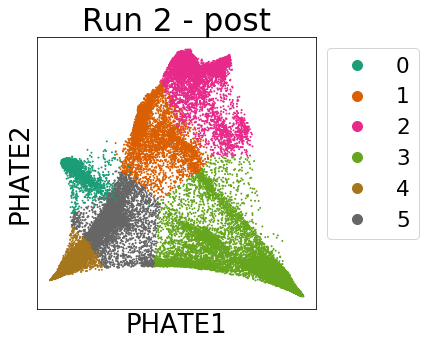

In [74]:
scprep.plot.scatter2d(data_phate, c=new_clusters, cmap='Dark2', 
                     title=title, ticks=False, label_prefix='PHATE', legend_anchor=(1,1), figsize=(5,5))

In [75]:
cluster_names = np.zeros(data.shape[0], dtype=object)


cname_map = {
    0:'CD3-/CD185+/FoxP3+',
    4:'Myeloid',
    2:'T exhausted',
    3:'T helper',
    1:'T cytotoxic',
    5:'Myeloid PDL1+'
}

cluster_names = np.array([cname_map[c] for c in new_clusters])

In [186]:
metadata['k20_clusters'] = clusters

In [100]:
metadata['clusters'] = cluster_names

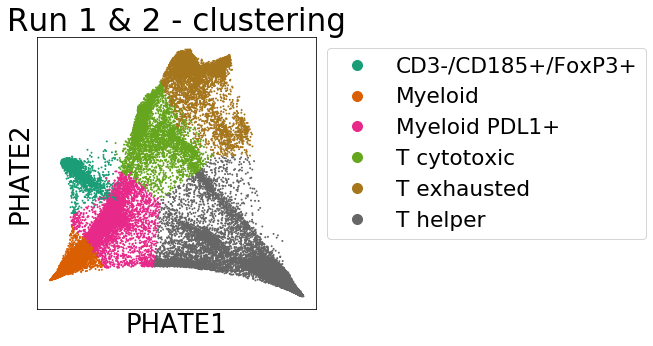

In [101]:
scprep.plot.scatter2d(data_phate, c=metadata['clusters'], cmap='Dark2', 
                     title='Run 1 & 2 - clustering', ticks=False, label_prefix='PHATE', legend_anchor=(1,1), figsize=(5,5))

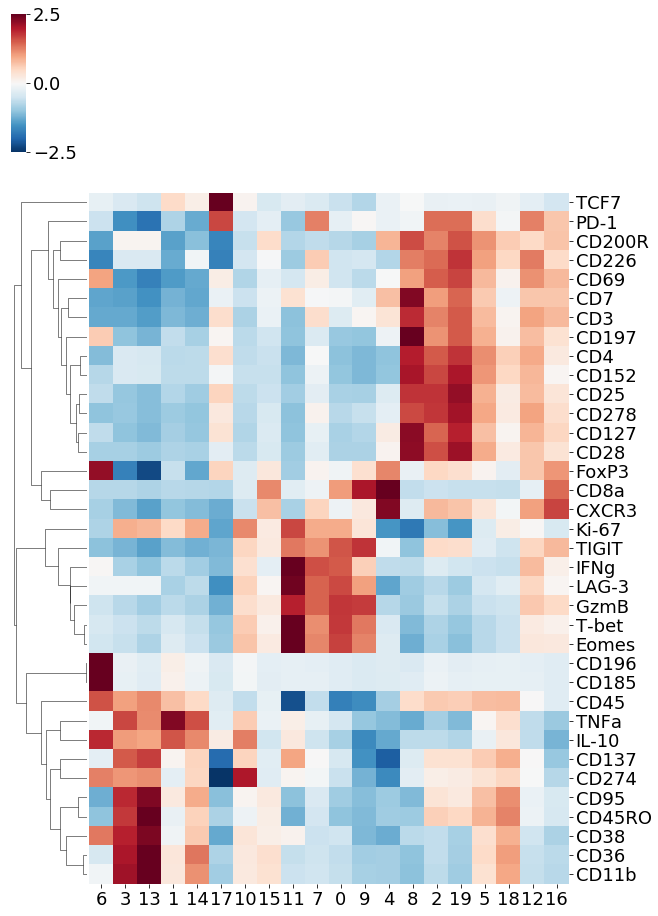

In [181]:
from scipy import stats

# Expression
marker_expression = data_magic.groupby(clusters).mean().T
marker_expression_zs = stats.zscore(marker_expression, axis=1)

# Heatmap
cg = sns.clustermap(marker_expression_zs, cmap='RdBu_r', 
                    yticklabels=data_magic.columns,
                    xticklabels=np.arange(len(np.unique(clusters))),
                    figsize=(10,16), vmin=2.5, vmax=-2.5, 
                    cbar_kws={"ticks":[-2.5, 0, 2.5]},
                    col_cluster=True)

cg.ax_heatmap.set_xticklabels(cg.ax_heatmap.get_xticklabels(), rotation=0)

#scprep.plot.utils.shift_ticklabels(cg.ax_heatmap.xaxis, dx=0.15)
cg.ax_col_dendrogram.set_visible(False)


#cg.savefig(os.path.join(fig_dir, 'clusters.new.heatmap.png'), dpi=300, transparent=True)

In [ ]:
new_clusters = np.zeros(len(clusters), dtype=int)

new_clusters[clusters == 6] = 1
new_clusters[(clusters == 3) | (clusters == 13)] = 2
new_clusters[(clusters == 1) | (clusters == 14) | (clusters == 18)] = 2
new_clusters[(clusters == 17)] = 8
new_clusters[(clusters == 10)] = 5
new_clusters[(clusters == 15) | (clusters == 7) | (clusters == 4) | (clusters == 16)] = 6
new_clusters[(clusters == 11) | (clusters == 0) | (clusters == 9)] = 7
new_clusters[(clusters == 8)  | (clusters == 2) | (clusters == 19) | (clusters == 5) | (clusters == 12)] = 8

In [13]:
cname_map = {
    1:'CD3-/CD185+/\nFoxP3+',
    2:'Myeloid',
    #3:'Myeloid: TNFa-hi/IL-10hi',
    #4:'Th: TCF7-hi/PD-1hi',
    5:'T cytotoxic\nPDL1-hi',
    6:'T exhuasted',
    7:'T cytotoxic',
    8:'T helper',
}

#k20_cluster_names = np.array([cname_map[cn] for cn in new_clusters])
#metadata['k20_clusters'] = k20_cluster_names

NameError: name 'new_clusters' is not defined

In [12]:
cluster_cmap = {cn:sns.husl_palette(len(np.unique(k20_cluster_names)))[i] for i, cn in enumerate(np.unique(metadata['k20_clusters']))}

NameError: name 'k20_cluster_names' is not defined

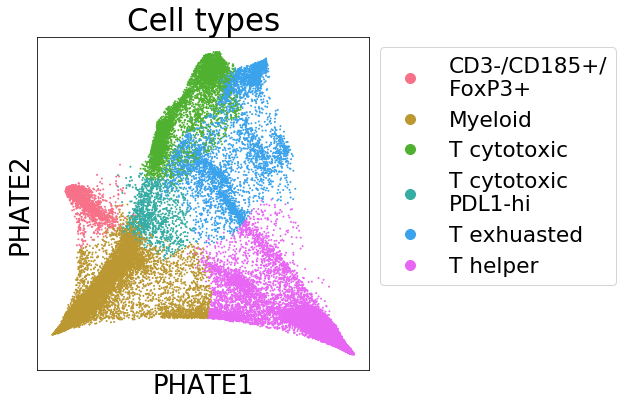

In [258]:
fig, ax = plt.subplots(1, figsize=(9,6))

scprep.plot.scatter2d(data_phate, c=k20_cluster_names, cmap=cluster_cmap, 
                     title='Cell types', ticks=False, label_prefix='PHATE', legend_anchor=(1,1), ax=ax)

fig.tight_layout()
fig.savefig('../figs/runs_combined.pre_and_post/PHATE_clusters.png', dpi=300)

In [11]:
from scipy import stats

# Expression
marker_expression = data_magic.groupby(metadata['k20_clusters']).mean().T
marker_expression_zs = stats.zscore(marker_expression, axis=1)

# Heatmap
cg = sns.clustermap(marker_expression_zs, cmap='RdBu_r', 
                    yticklabels=data_magic.columns,
                    xticklabels=[cname_map[c] for c in np.unique(metadata['k20_clusters'])],
                    figsize=(10,16), vmin=2.5, vmax=-2.5, 
                    cbar_kws={"ticks":[-2.5, 0, 2.5]},
                    col_cluster=True)

cg.ax_heatmap.set_xticklabels(cg.ax_heatmap.get_xticklabels(), rotation=45, ha='right')

scprep.plot.utils.shift_ticklabels(cg.ax_heatmap.xaxis, dx=0.15)
cg.ax_col_dendrogram.set_visible(False)


cg.savefig(os.path.join(fig_dir, 'clusters.new.heatmap.png'), dpi=300, transparent=True)

NameError: name 'cname_map' is not defined

In [297]:
data_magic.to_pickle('/home/dan/data/burkhardt/sbrt_trial/run1_and_2.pre_and_post.data_magic.pkl')

In [298]:
np.savez('/home/dan/data/burkhardt/sbrt_trial/run1_and_2.pre_and_post.phate.npz', data_phate=data_phate)

In [301]:
data.to_pickle('/home/dan/data/burkhardt/sbrt_trial/run1_and_2.pre_and_post.data.pkl')
metadata.to_pickle('/home/dan/data/burkhardt/sbrt_trial/run1_and_2.pre_and_post.metadata.pkl')

### Load data

In [3]:
data_magic = pd.read_pickle('/home/dan/data/burkhardt/sbrt_trial/run1_and_2.pre_and_post.data_magic.pkl')
data = pd.read_pickle('/home/dan/data/burkhardt/sbrt_trial/run1_and_2.pre_and_post.data.pkl')
metadata = pd.read_pickle('/home/dan/data/burkhardt/sbrt_trial/run1_and_2.pre_and_post.metadata.pkl')

In [4]:
data_phate = np.load('/home/dan/data/burkhardt/sbrt_trial/run1_and_2.pre_and_post.phate.npz')['data_phate']

In [5]:
cluster_names = metadata['k20_clusters'].values.copy()
np.unique(cluster_names)

array(['CD3-/CD185+/\nFoxP3+', 'Myeloid', 'T cytotoxic',
       'T cytotoxic\nPDL1-hi', 'T exhuasted', 'T helper'], dtype=object)

In [6]:
cluster_names[cluster_names == 'Myeloid'] = 'CD11b+'
cluster_names[cluster_names == 'T cytotoxic\nPDL1-hi'] = 'CD11b+/PDL1+'
np.unique(cluster_names)

array(['CD11b+', 'CD11b+/PDL1+', 'CD3-/CD185+/\nFoxP3+', 'T cytotoxic',
       'T exhuasted', 'T helper'], dtype=object)

In [7]:
metadata['k20_clusters'] = cluster_names

In [8]:
cname_map = {
    1:'CD3-/CD185+/\nFoxP3+',
    2:'CD11b+',
    #3:'Myeloid: TNFa-hi/IL-10hi',
    #4:'Th: TCF7-hi/PD-1hi',
    5:'CD11b+/PDL1+',
    6:'T exhuasted',
    7:'T cytotoxic',
    8:'T helper',
}

In [9]:
cluster_cmap = {cn:sns.husl_palette(len(np.unique(metadata['k20_clusters'])))[i] for i, cn in enumerate(np.unique(metadata['k20_clusters']))}

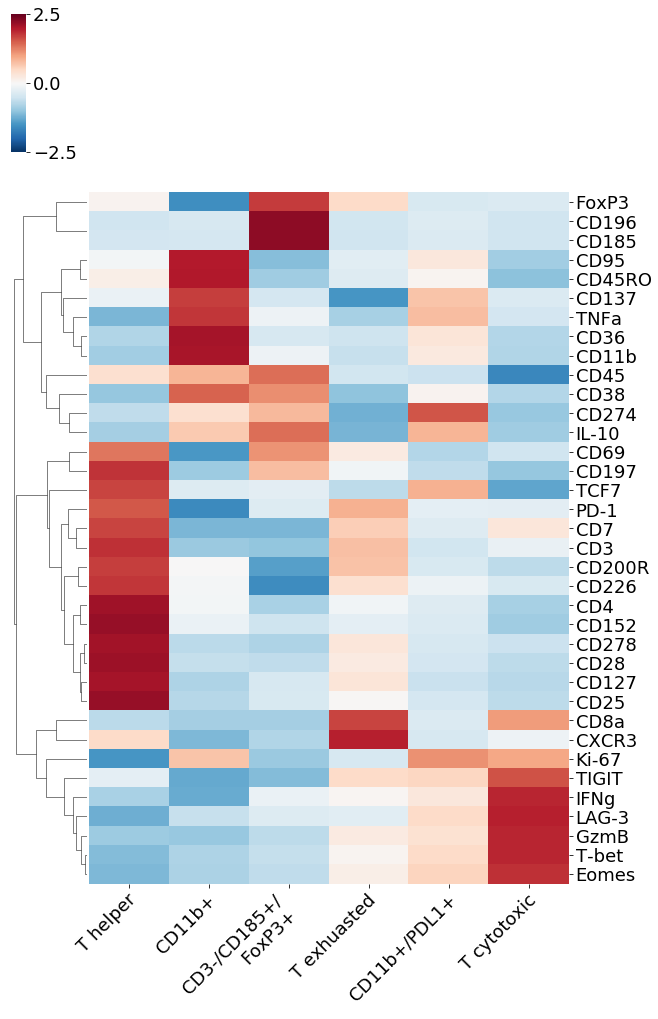

In [16]:
from scipy import stats

# Expression
marker_expression = data_magic.groupby(metadata['k20_clusters']).mean().T
marker_expression_zs = stats.zscore(marker_expression, axis=1)

# Heatmap
cg = sns.clustermap(marker_expression_zs, cmap='RdBu_r', 
                    yticklabels=data_magic.columns,
                    xticklabels=np.unique(metadata['k20_clusters']),
                    figsize=(10,16), vmin=2.5, vmax=-2.5, 
                    cbar_kws={"ticks":[-2.5, 0, 2.5]},
                    col_cluster=True)

cg.ax_heatmap.set_xticklabels(cg.ax_heatmap.get_xticklabels(), rotation=45, ha='right')

scprep.plot.utils.shift_ticklabels(cg.ax_heatmap.xaxis, dx=0.15)
cg.ax_col_dendrogram.set_visible(False)


cg.savefig(os.path.join(fig_dir, 'clusters.new.heatmap.png'), dpi=300, transparent=True)

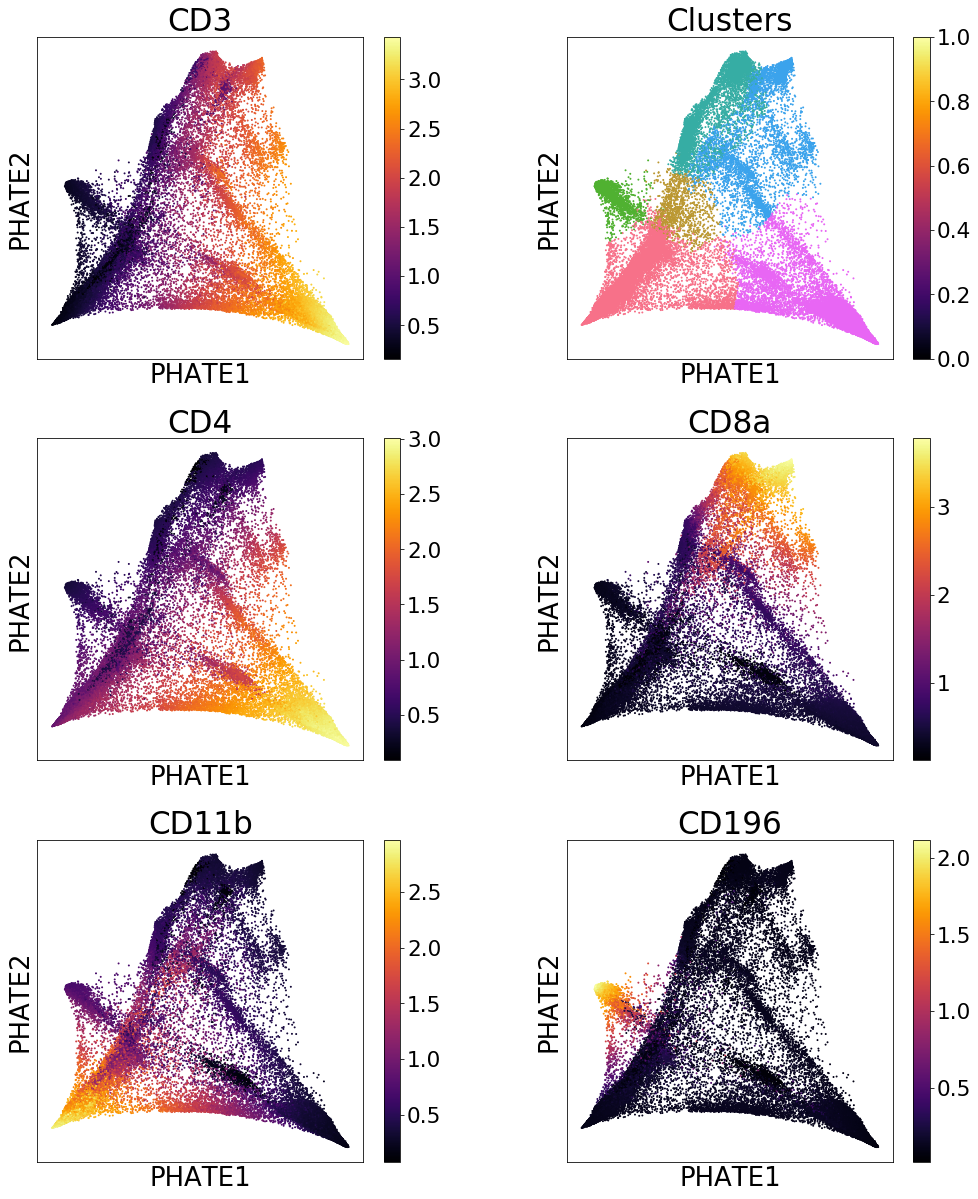

In [17]:
fig, axes = plt.subplots(3,2, figsize=(14, 17))
axes = axes.flatten()

markers = ['CD3', 'CD4', 'CD8a', 'CD11b', 'CD196']

mi = 0
for i , ax in enumerate(axes):
    if i == 1:
        cvec = metadata['k20_clusters']
        legend=False
        title='Clusters'
        cmap = cluster_cmap
    else:
        curr_marker = markers[mi]
        cvec = data_magic[curr_marker]
        title = curr_marker
        legend=True
        cmap = 'inferno'
        mi += 1
        
    scprep.plot.scatter2d(data_phate, c=cvec, cmap=cmap, 
                     title=title, ticks=False, label_prefix='PHATE', 
                          legend=legend, legend_anchor=(1,1), ax=ax)
    if i == 1:
        scprep.plot.tools.generate_colorbar(cmap='inferno', vmin=0, vmax=1, ax=ax)
    
fig.tight_layout(w_pad=5)
#fig.savefig('../figs/runs_combined.pre_and_post/PHATE_clusters.markers.png', dpi=300)

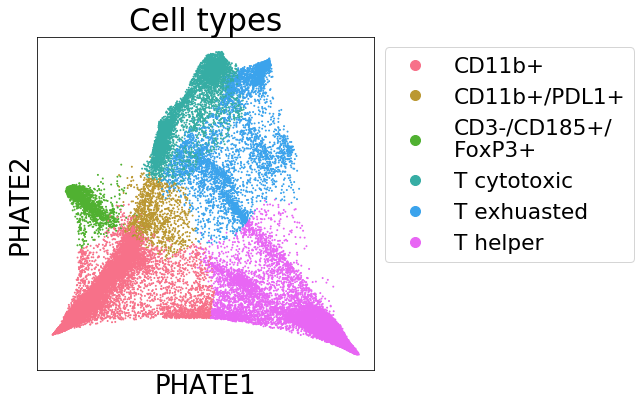

In [19]:
fig, ax = plt.subplots(1, figsize=(9.25,6))

scprep.plot.scatter2d(data_phate, c=metadata['k20_clusters'], cmap=cluster_cmap, 
                     title='Cell types', ticks=False, label_prefix='PHATE', legend_anchor=(1,1), ax=ax)

fig.tight_layout()
fig.savefig('../figs/runs_combined.pre_and_post/PHATE_clusters.png', dpi=300)

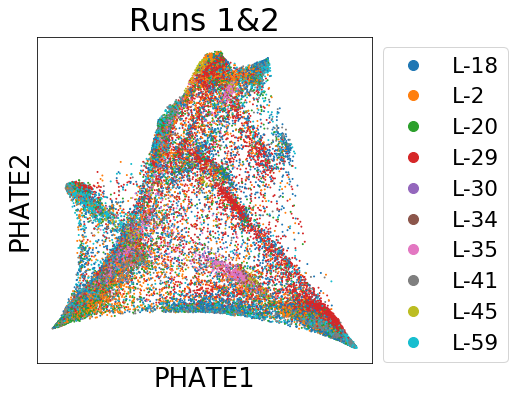

In [106]:
scprep.plot.scatter2d(data_phate, c=metadata['sample_id'], cmap='tab10', legend_anchor=(1,1),
                     title='Runs 1&2', figsize=(6,6), ticks=False, label_prefix='PHATE')

In [11]:
response_cmap = {
    'Poor':'#0a516d',
    'Fair':'#738598',
    'Excellent':'#f77754'
}

time_cmap = {'Very Pre': '#b3cde3',
    'Pre': '#8c96c6',
    'Post-1':'#88419d'}

In [21]:
metadata.head()

sample  \
0_L-18_Excellent_Post-1  L-18_Excellent_Post-1   
1_L-18_Excellent_Post-1  L-18_Excellent_Post-1   
2_L-18_Excellent_Post-1  L-18_Excellent_Post-1   
3_L-18_Excellent_Post-1  L-18_Excellent_Post-1   
4_L-18_Excellent_Post-1  L-18_Excellent_Post-1   

                                                          filename sample_id  \
0_L-18_Excellent_Post-1  L-18_052016_Post-SBRT.Stimulated.A-B1.fcs      L-18   
1_L-18_Excellent_Post-1  L-18_052016_Post-SBRT.Stimulated.A-B1.fcs      L-18   
2_L-18_Excellent_Post-1  L-18_052016_Post-SBRT.Stimulated.A-B1.fcs      L-18   
3_L-18_Excellent_Post-1  L-18_052016_Post-SBRT.Stimulated.A-B1.fcs      L-18   
4_L-18_Excellent_Post-1  L-18_052016_Post-SBRT.Stimulated.A-B1.fcs      L-18   

                            date stimulated pre_post_sbrt  time_RES  \
0_L-18_Excellent_Post-1  5/20/16          Y        Post-1         1   
1_L-18_Excellent_Post-1  5/20/16          Y        Post-1         1   
2_L-18_Excellent_Post-1  5/20/16          Y        Post-1         1   
3_L-18_Excellent_Post-1  5/20/16          Y        Post-1         1   
4_L-18_Excellent_Post-1  5/20/16          Y        Post-1         1   

                          response  response_RES  days_to_progression  run  \
0_L-18_Excellent_Post-1  Excellent             1                  377    1   
1_L-18_Excellent_Post-1  Excellent             1                  377    1   
2_L-18_Excellent_Post-1  Excellent             1                  377    1   
3_L-18_Excellent_Post-1  Excellent             1                  377    1   
4_L-18_Excellent_Post-1  Excellent             1                  377    1   

                         progression_RES       clusters  response_EES  \
0_L-18_Excellent_Post-1         0.956873        Myeloid      0.002586   
1_L-18_Excellent_Post-1         0.956873        Myeloid      0.019020   
2_L-18_Excellent_Post-1         0.956873        Myeloid      0.003387   
3_L-18_Excellent_Post-1         0.956873  Myeloid PDL1+      0.025341   
4_L-18_Excellent_Post-1         0.956873    T exhausted      0.042486   

                        k20_clusters  response_combined_EES  
0_L-18_Excellent_Post-1       CD11b+               0.004957  
1_L-18_Excellent_Post-1       CD11b+               0.019099  
2_L-18_Excellent_Post-1       CD11b+               0.005642  
3_L-18_Excellent_Post-1       CD11b+               0.027284  
4_L-18_Excellent_Post-1  T cytotoxic               0.023940

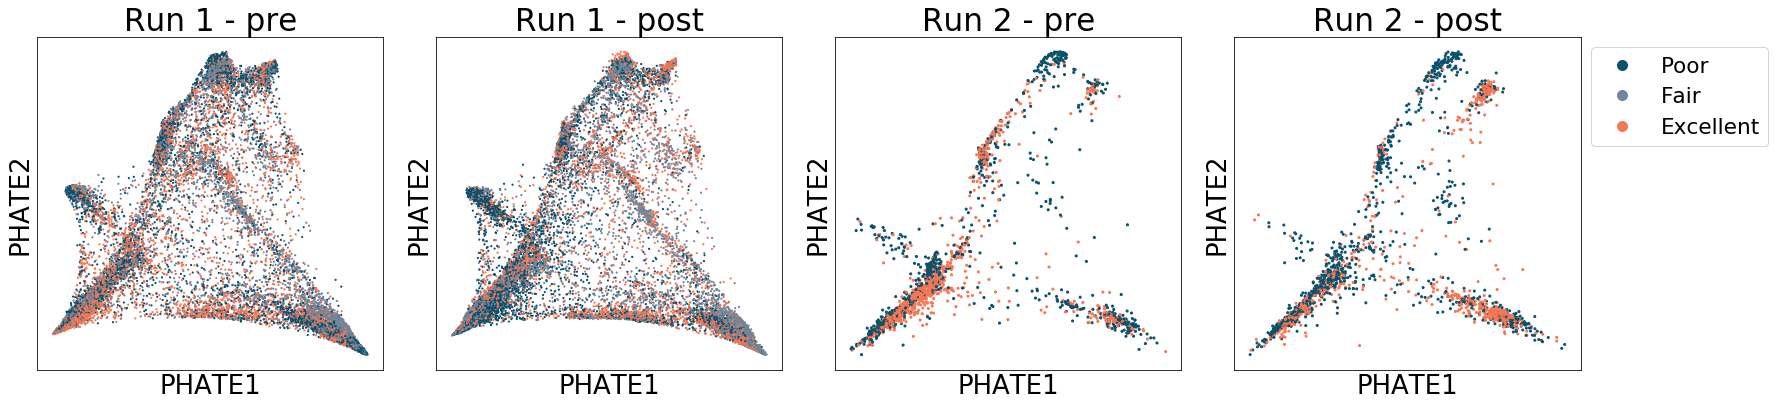

In [26]:
fig, axes = plt.subplots(1,4, figsize=(25,6))

for i, ax in enumerate(axes):
    if i == 0:
        curr_mask = (metadata['run'] == 1) & (metadata['time_RES'] < 0)
        curr_cvec = metadata['response']
        title = 'Run 1 - pre'
        legend=False
    elif i == 1:
        curr_mask = (metadata['run'] == 1) & (metadata['time_RES'] > 0)
        curr_cvec = metadata['response']
        title = 'Run 1 - post'
        legend=False
    elif i == 2:
        curr_mask = (metadata['run'] == 2) & (metadata['time_RES'] < 0)
        curr_cvec = metadata['response']
        legend=False
        title = 'Run 2 - pre'
    elif i == 3:
        curr_mask = (metadata['run'] == 2) & (metadata['time_RES'] > 0)
        curr_cvec = metadata['response']
        title = 'Run 2 - post'
        legend=True
    scprep.plot.scatter2d(data_phate[curr_mask], c=curr_cvec[curr_mask], cmap=cmap, 
                     title=title, ticks=False, label_prefix='PHATE', ax=ax,
                          legend=legend, legend_anchor=(1,1))
    
fig.tight_layout()

In [12]:
metadata['response_combined_EES'] = combined_response_ees

NameError: name 'combined_response_ees' is not defined

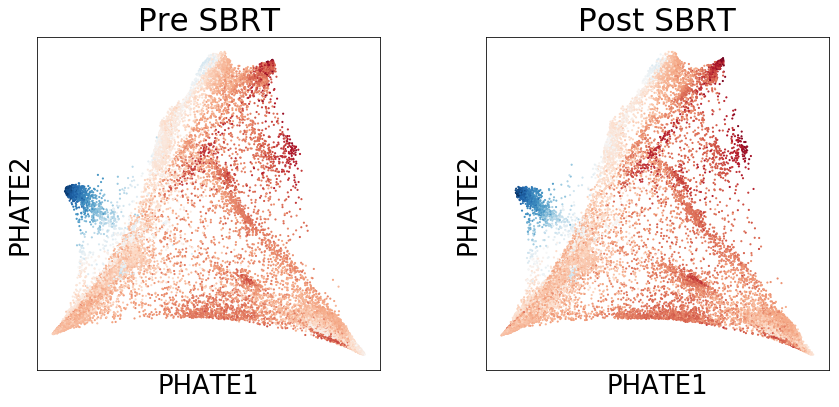

In [282]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

for i, ax in enumerate(axes):
    if i == 0:
        curr_mask = metadata['time_RES'] < 0
        curr_cvec = combined_response_ees
        title = 'Pre SBRT'
        legend=False
    elif i == 1:
        curr_mask = metadata['time_RES'] > 0
        curr_cvec = combined_response_ees
        title = 'Post SBRT'
        legend = False
    
    scprep.plot.scatter2d(data_phate[curr_mask], c=curr_cvec[curr_mask], cmap='RdBu_r', 
                     title=title, ticks=False, label_prefix='PHATE', ax=ax,
                          legend=legend, legend_anchor=(1,1))
fig.tight_layout(w_pad=4)
fig.savefig('../figs/runs_combined.pre_and_post/PHATE.combined_response_EES.png', dpi=300)

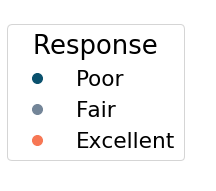

In [296]:
fig, ax = plt.subplots(1, figsize=(3,3))
scprep.plot.tools.generate_legend(response_cmap, ax, title='Response')
ax.axis('off')
fig.tight_layout()
fig.savefig('../figs/runs_combined.pre_and_post/response_legend.png', dpi=300)

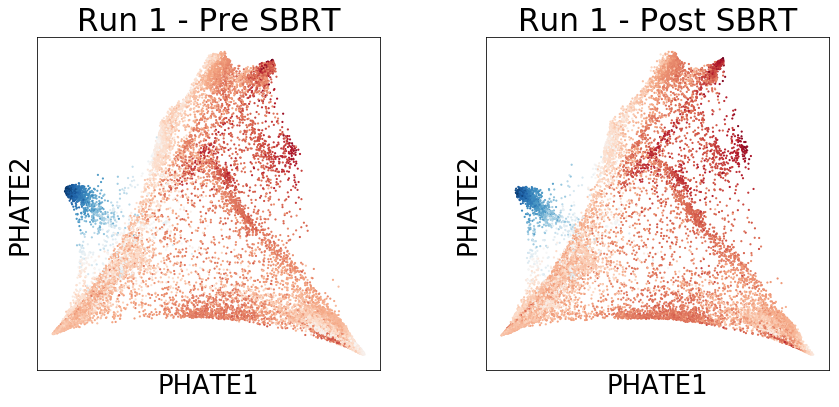

In [279]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

for i, ax in enumerate(axes):
    if i == 0:
        curr_mask = (metadata['run'] == 1) & (metadata['time_RES'] < 0)
        curr_cvec = metadata['response_EES']
        title = 'Run 1 - Pre SBRT'
        legend=False
    elif i == 1:
        curr_mask = (metadata['run'] == 1) & (metadata['time_RES'] > 0)
        curr_cvec = metadata['response_EES']
        title = 'Run 1 - Post SBRT'
        legend = False
    
    scprep.plot.scatter2d(data_phate[curr_mask], c=curr_cvec[curr_mask], cmap='RdBu_r', 
                     title=title, ticks=False, label_prefix='PHATE', ax=ax,
                          legend=legend, legend_anchor=(1,1))
fig.tight_layout(w_pad=4)
fig.savefig('../figs/runs_combined.pre_and_post/PHATE_response_EES.png', dpi=300)

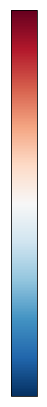

In [295]:
fig, ax = plt.subplots(1, figsize=(1,6))

#fig.colorbar(cmap='RdBu_r', cax=ax)
scprep.plot.tools.generate_colorbar(cmap='RdBu_r', ax=ax, cax=ax)
fig.tight_layout()
fig.savefig('../figs/runs_combined.pre_and_post/colorbar.png', dpi=300)

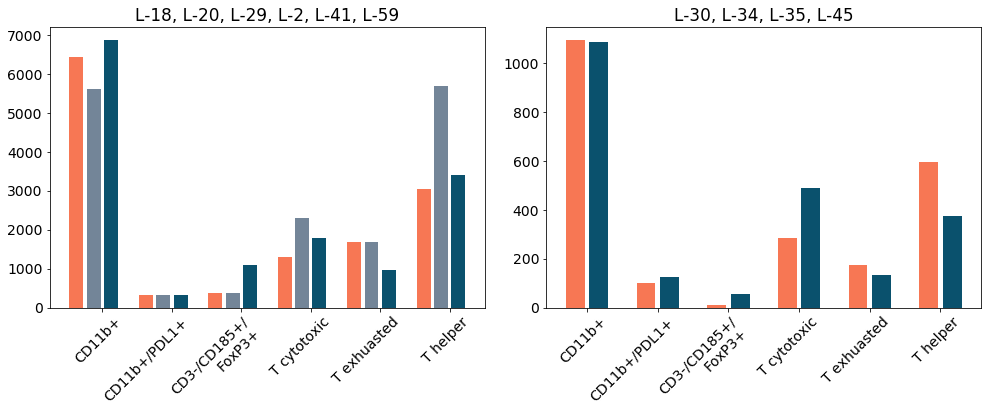

In [13]:
fig, axes = plt.subplots(1,2, figsize=(14,6))
axes = axes.flatten()

for r, curr_run in enumerate(np.unique(metadata['run'])):
    curr_run_mask = metadata['run'] == curr_run
    ax = axes[r]
    i= -1
    ticks = []
    ticklabels = []
    for clust in np.unique(metadata['k20_clusters']):
        curr_clust_mask = metadata['k20_clusters'] == clust
        curr_data = metadata.loc[curr_run_mask & curr_clust_mask]
        curr_counts = curr_data['k20_clusters'].groupby(metadata['response']).count()
        for j, resp in enumerate(np.unique(curr_data['response'])):
            i += 1
            ax.bar(i, curr_counts[resp], color=response_cmap[resp])
            if resp == 'Poor':
                ticks.append(i - 0.5 )
                ticklabels.append(clust)
        i += 1
        ax.set_xticks(ticks)
        ax.set_xticklabels(ticklabels, rotation=45, ha='right')
        scprep.plot.utils.shift_ticklabels(ax.xaxis, dx=.05)
        ax.set_title(', '.join(metadata[curr_run_mask]['sample_id'].unique()))

fig.tight_layout()
#fig.savefig('../figs/runs_combined.pre_and_post/cell_type_abundance.horizontal.png', dpi=300)

In [14]:
exp = data['CD274']

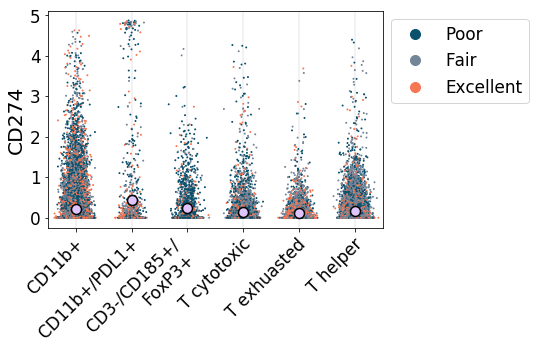

In [27]:
ax = scprep.plot.jitter(labels=metadata['k20_clusters'], values=exp, 
                        ylabel='CD274', c=metadata['response'], cmap=response_cmap,
                       legend_anchor=(1,1))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
scprep.plot.utils.shift_ticklabels(ax.xaxis, dx=.15)

In [ ]:
exp = data['CD274']
ax = scprep.plot.jitter(labels=metadata['k20_clusters'], values=exp, 
                        ylabel='CD274', c=metadata['response'], cmap=response_cmap,
                       legend_anchor=(1,1))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
scprep.plot.utils.shift_ticklabels(ax.xaxis, dx=.15)

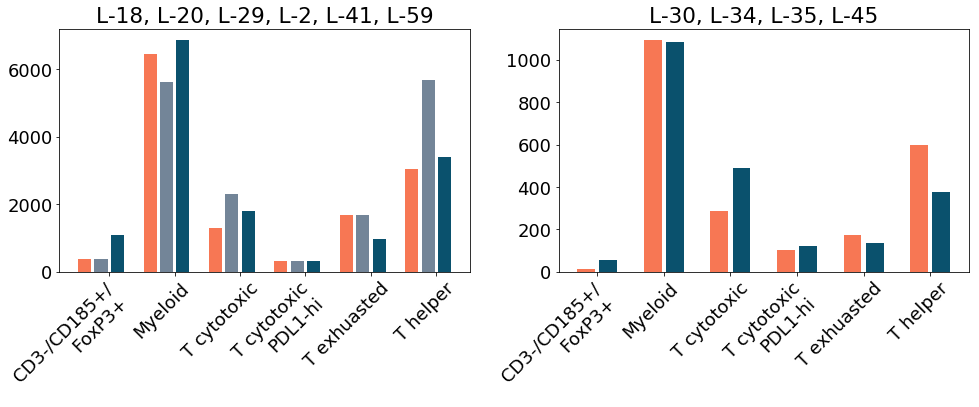

In [288]:
fig, axes = plt.subplots(1,2, figsize=(14,6))
axes = axes.flatten()

for r, curr_run in enumerate(np.unique(metadata['run'])):
    curr_run_mask = metadata['run'] == curr_run
    ax = axes[r]
    i= -1
    ticks = []
    ticklabels = []
    for clust in np.unique(metadata['k20_clusters']):
        curr_clust_mask = metadata['k20_clusters'] == clust
        curr_data = metadata.loc[curr_run_mask & curr_clust_mask]
        curr_counts = curr_data['k20_clusters'].groupby(metadata['response']).count()
        for j, resp in enumerate(np.unique(curr_data['response'])):
            i += 1
            ax.bar(i, curr_counts[resp], color=response_cmap[resp])
            if resp == 'Poor':
                ticks.append(i - 0.5 )
                ticklabels.append(clust)
        i += 1
        ax.set_xticks(ticks)
        ax.set_xticklabels(ticklabels, rotation=45, ha='right')
        scprep.plot.utils.shift_ticklabels(ax.xaxis, dx=.05)
        ax.set_title(', '.join(metadata[curr_run_mask]['sample_id'].unique()))

fig.tight_layout()
fig.savefig('../figs/runs_combined.pre_and_post/cell_type_abundance.horizontal.png', dpi=300)

In [285]:
', '.join(metadata[curr_run_mask]['sample_id'].unique())

'L-30, L-34, L-35, L-45'

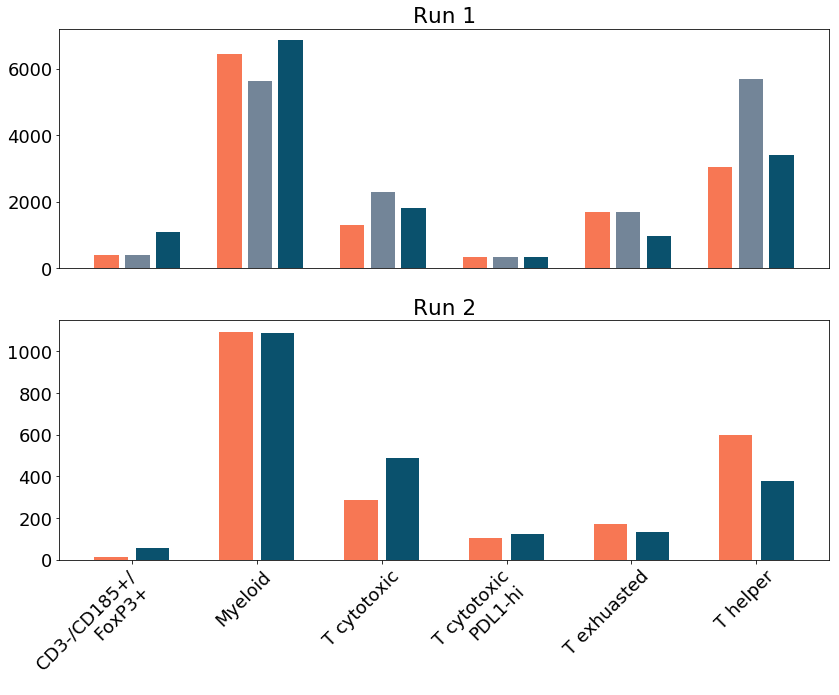

In [248]:
fig, axes = plt.subplots(2,1, figsize=(12,10))
axes = axes.flatten()

for r, curr_run in enumerate(np.unique(metadata['run'])):
    curr_run_mask = metadata['run'] == curr_run
    ax = axes[r]
    i= -1
    ticks = []
    ticklabels = []
    for clust in np.unique(metadata['k20_clusters']):
        curr_clust_mask = metadata['k20_clusters'] == clust
        curr_data = metadata.loc[curr_run_mask & curr_clust_mask]
        curr_counts = curr_data['k20_clusters'].groupby(metadata['response']).count()
        for j, resp in enumerate(np.unique(curr_data['response'])):
            i += 1
            ax.bar(i, curr_counts[resp], color=response_cmap[resp])
            if resp == 'Poor':
                ticks.append(i - 0.5 )
                ticklabels.append(clust)
        i += 1
        if curr_run == 2:
            ax.set_xticks(ticks)
            ax.set_xticklabels(ticklabels, rotation=45, ha='right')
            scprep.plot.utils.shift_ticklabels(ax.xaxis, dx=.05)
        else:
            ax.set_xticks([])
        ax.set_title('Run {}'.format(curr_run))

fig.tight_layout()
fig.savefig('../figs/runs_combined.pre_and_post/cell_type_abundance.png', dpi=300)

## MELD

In [22]:
metadata.head()

sample  \
0_L-18_Excellent_Post-1  L-18_Excellent_Post-1   
1_L-18_Excellent_Post-1  L-18_Excellent_Post-1   
2_L-18_Excellent_Post-1  L-18_Excellent_Post-1   
3_L-18_Excellent_Post-1  L-18_Excellent_Post-1   
4_L-18_Excellent_Post-1  L-18_Excellent_Post-1   

                                                          filename sample_id  \
0_L-18_Excellent_Post-1  L-18_052016_Post-SBRT.Stimulated.A-B1.fcs      L-18   
1_L-18_Excellent_Post-1  L-18_052016_Post-SBRT.Stimulated.A-B1.fcs      L-18   
2_L-18_Excellent_Post-1  L-18_052016_Post-SBRT.Stimulated.A-B1.fcs      L-18   
3_L-18_Excellent_Post-1  L-18_052016_Post-SBRT.Stimulated.A-B1.fcs      L-18   
4_L-18_Excellent_Post-1  L-18_052016_Post-SBRT.Stimulated.A-B1.fcs      L-18   

                            date stimulated pre_post_sbrt  time_RES  \
0_L-18_Excellent_Post-1  5/20/16          Y        Post-1         1   
1_L-18_Excellent_Post-1  5/20/16          Y        Post-1         1   
2_L-18_Excellent_Post-1  5/20/16          Y        Post-1         1   
3_L-18_Excellent_Post-1  5/20/16          Y        Post-1         1   
4_L-18_Excellent_Post-1  5/20/16          Y        Post-1         1   

                          response  response_RES  days_to_progression  run  \
0_L-18_Excellent_Post-1  Excellent             1                  377    1   
1_L-18_Excellent_Post-1  Excellent             1                  377    1   
2_L-18_Excellent_Post-1  Excellent             1                  377    1   
3_L-18_Excellent_Post-1  Excellent             1                  377    1   
4_L-18_Excellent_Post-1  Excellent             1                  377    1   

                         progression_RES       clusters  response_EES  \
0_L-18_Excellent_Post-1         0.956873        Myeloid      0.002586   
1_L-18_Excellent_Post-1         0.956873        Myeloid      0.019020   
2_L-18_Excellent_Post-1         0.956873        Myeloid      0.003387   
3_L-18_Excellent_Post-1         0.956873  Myeloid PDL1+      0.025341   
4_L-18_Excellent_Post-1         0.956873    T exhausted      0.042486   

                        k20_clusters  response_combined_EES  
0_L-18_Excellent_Post-1       CD11b+               0.004957  
1_L-18_Excellent_Post-1       CD11b+               0.019099  
2_L-18_Excellent_Post-1       CD11b+               0.005642  
3_L-18_Excellent_Post-1       CD11b+               0.027284  
4_L-18_Excellent_Post-1  T cytotoxic               0.023940

In [23]:
G.knn, G.decay

NameError: name 'G' is not defined

In [24]:
1_2

12

In [26]:
response_ees = []
for curr_run in np.unique(metadata['run']):
    print(curr_run)
    curr_run_mask = metadata['run'] == curr_run
    G = gt.Graph(data[curr_run_mask], knn=20, decay=10, use_pygsp=True)
    print('built graph')
    curr_ees = meld.MELD().fit_transform(metadata[curr_run_mask]['response_RES'], G)
    curr_ees = curr_ees - np.mean(curr_ees)
    response_ees.append(curr_ees)
response_ees = np.hstack(response_ees)
metadata['response_EES'] = response_ees

1


KeyboardInterrupt: 

In [ ]:
G = gt.Graph(data, knn=20, decay=10, use_pygsp=True)
print('built graph')

In [29]:
combined_response_ees = meld.MELD().fit_transform(G, metadata['response_RES'])
combined_response_ees = combined_response_ees - np.mean(combined_response_ees)

In [30]:
response_ees = np.hstack(response_ees)

ValueError: need at least one array to concatenate

In [ ]:
metadata['response_EES'] = response_ees


In [31]:
metadata['combined_response_EES'] = combined_response_ees

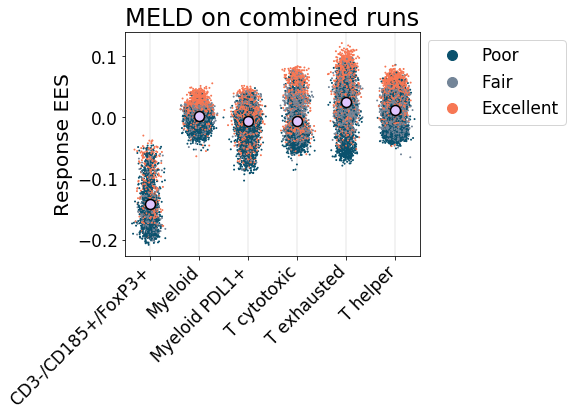

In [44]:
#curr_run_mask = metadata['run'] == 1
curr_data = metadata#[curr_run_mask]

ax = scprep.plot.jitter(curr_data['clusters'], 
                        curr_data['combined_response_EES'], c=curr_data['response'], 
                        cmap=response_cmap, legend_anchor=(1,1),
                       figsize=(8,6),ylabel='Response EES', title='MELD on combined runs')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
scprep.plot.utils.shift_ticklabels(ax.xaxis, dx=.05)
ax.figure.tight_layout()
ax.figure.savefig('../figs/jitter.response_EES.combined.png', dpi=300)

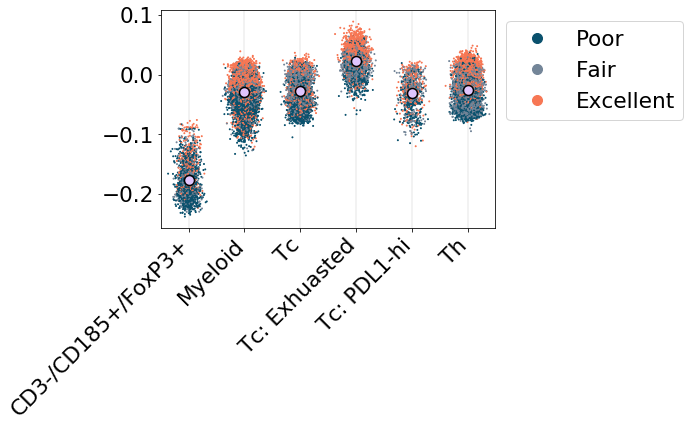

In [226]:
curr_run_mask = metadata['run'] == 1
curr_data = metadata[curr_run_mask]

ax = scprep.plot.jitter(curr_data['k20_clusters'], curr_data['response_EES'], c=curr_data['response'], cmap=response_cmap, legend_anchor=(1,1))

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
scprep.plot.utils.shift_ticklabels(ax.xaxis, dx=.05)


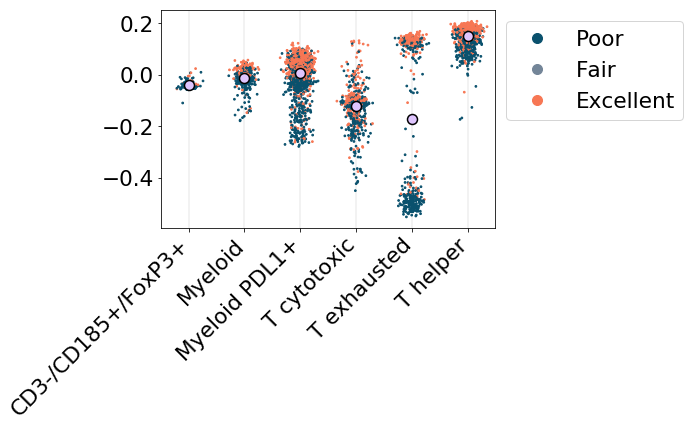

In [225]:
curr_run_mask = metadata['run'] == 2
curr_data = metadata[curr_run_mask]

ax = scprep.plot.jitter(curr_data['clusters'], curr_data['response_EES'], c=curr_data['response'], cmap=response_cmap, legend_anchor=(1,1))

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
scprep.plot.utils.shift_ticklabels(ax.xaxis, dx=.05)


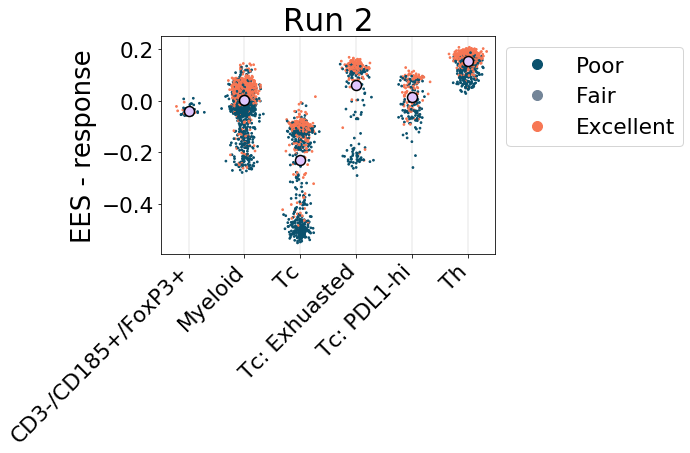

In [228]:
curr_run_mask = metadata['run'] == 2
curr_data = metadata[curr_run_mask]

ax = scprep.plot.jitter(curr_data['k20_clusters'], curr_data['response_EES'], c=curr_data['response'], cmap=response_cmap, legend_anchor=(1,1),
                       title='Run 2', ylabel='EES - response')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
scprep.plot.utils.shift_ticklabels(ax.xaxis, dx=.05)


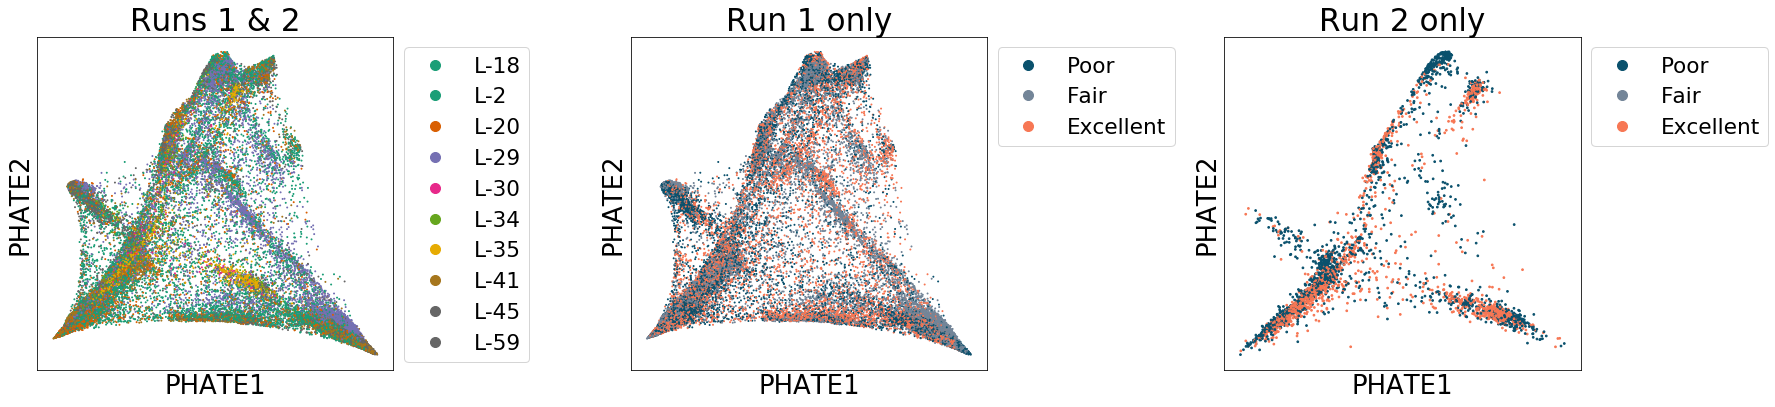

In [12]:
fig, axes = plt.subplots(1,3, figsize=(25,6))

for i, ax in enumerate(axes):
    if i == 0:
        curr_mask = metadata['run'] > 0
        curr_cvec = metadata['sample_id']
        title = 'Runs 1 & 2'
        cmap = 'Dark2'
    elif i == 1:
        curr_mask = metadata['run'] == 1
        curr_cvec = metadata['response']
        title = 'Run 1 only'
        cmap = response_cmap
    elif i == 2:
        curr_mask = metadata['run'] == 2
        curr_cvec = metadata['response']
        title = 'Run 2 only'
        cmap = response_cmap
    
    scprep.plot.scatter2d(data_phate[curr_mask], c=curr_cvec[curr_mask], cmap=cmap, 
                     title=title, ticks=False, label_prefix='PHATE', ax=ax, legend_anchor=(1,1))
    
fig.tight_layout()

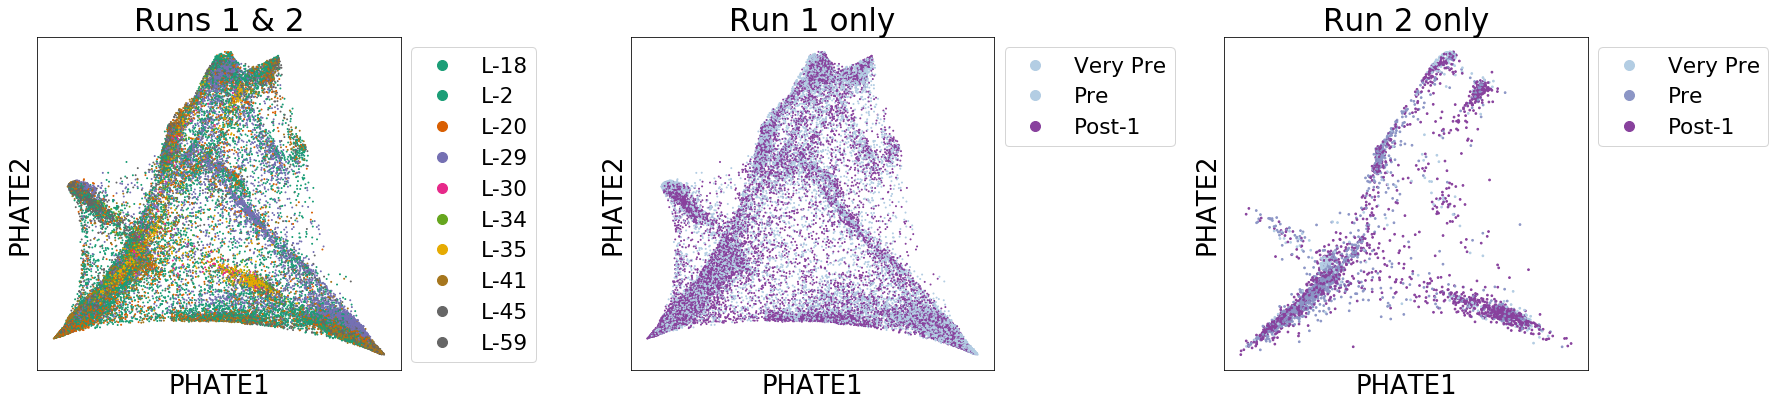

In [19]:
fig, axes = plt.subplots(1,3, figsize=(25,6))

for i, ax in enumerate(axes):
    if i == 0:
        curr_mask = metadata['run'] > 0
        curr_cvec = metadata['sample_id']
        title = 'Runs 1 & 2'
        cmap = 'Dark2'
    elif i == 1:
        curr_mask = metadata['run'] == 1
        curr_cvec = metadata['pre_post_sbrt']
        title = 'Run 1 only'
        cmap = time_cmap
    elif i == 2:
        curr_mask = metadata['run'] == 2
        curr_cvec = metadata['pre_post_sbrt']
        title = 'Run 2 only'
        cmap = time_cmap
    
    scprep.plot.scatter2d(data_phate[curr_mask], c=curr_cvec[curr_mask], cmap=cmap, 
                     title=title, ticks=False, label_prefix='PHATE', ax=ax, legend_anchor=(1,1))
    
fig.tight_layout()

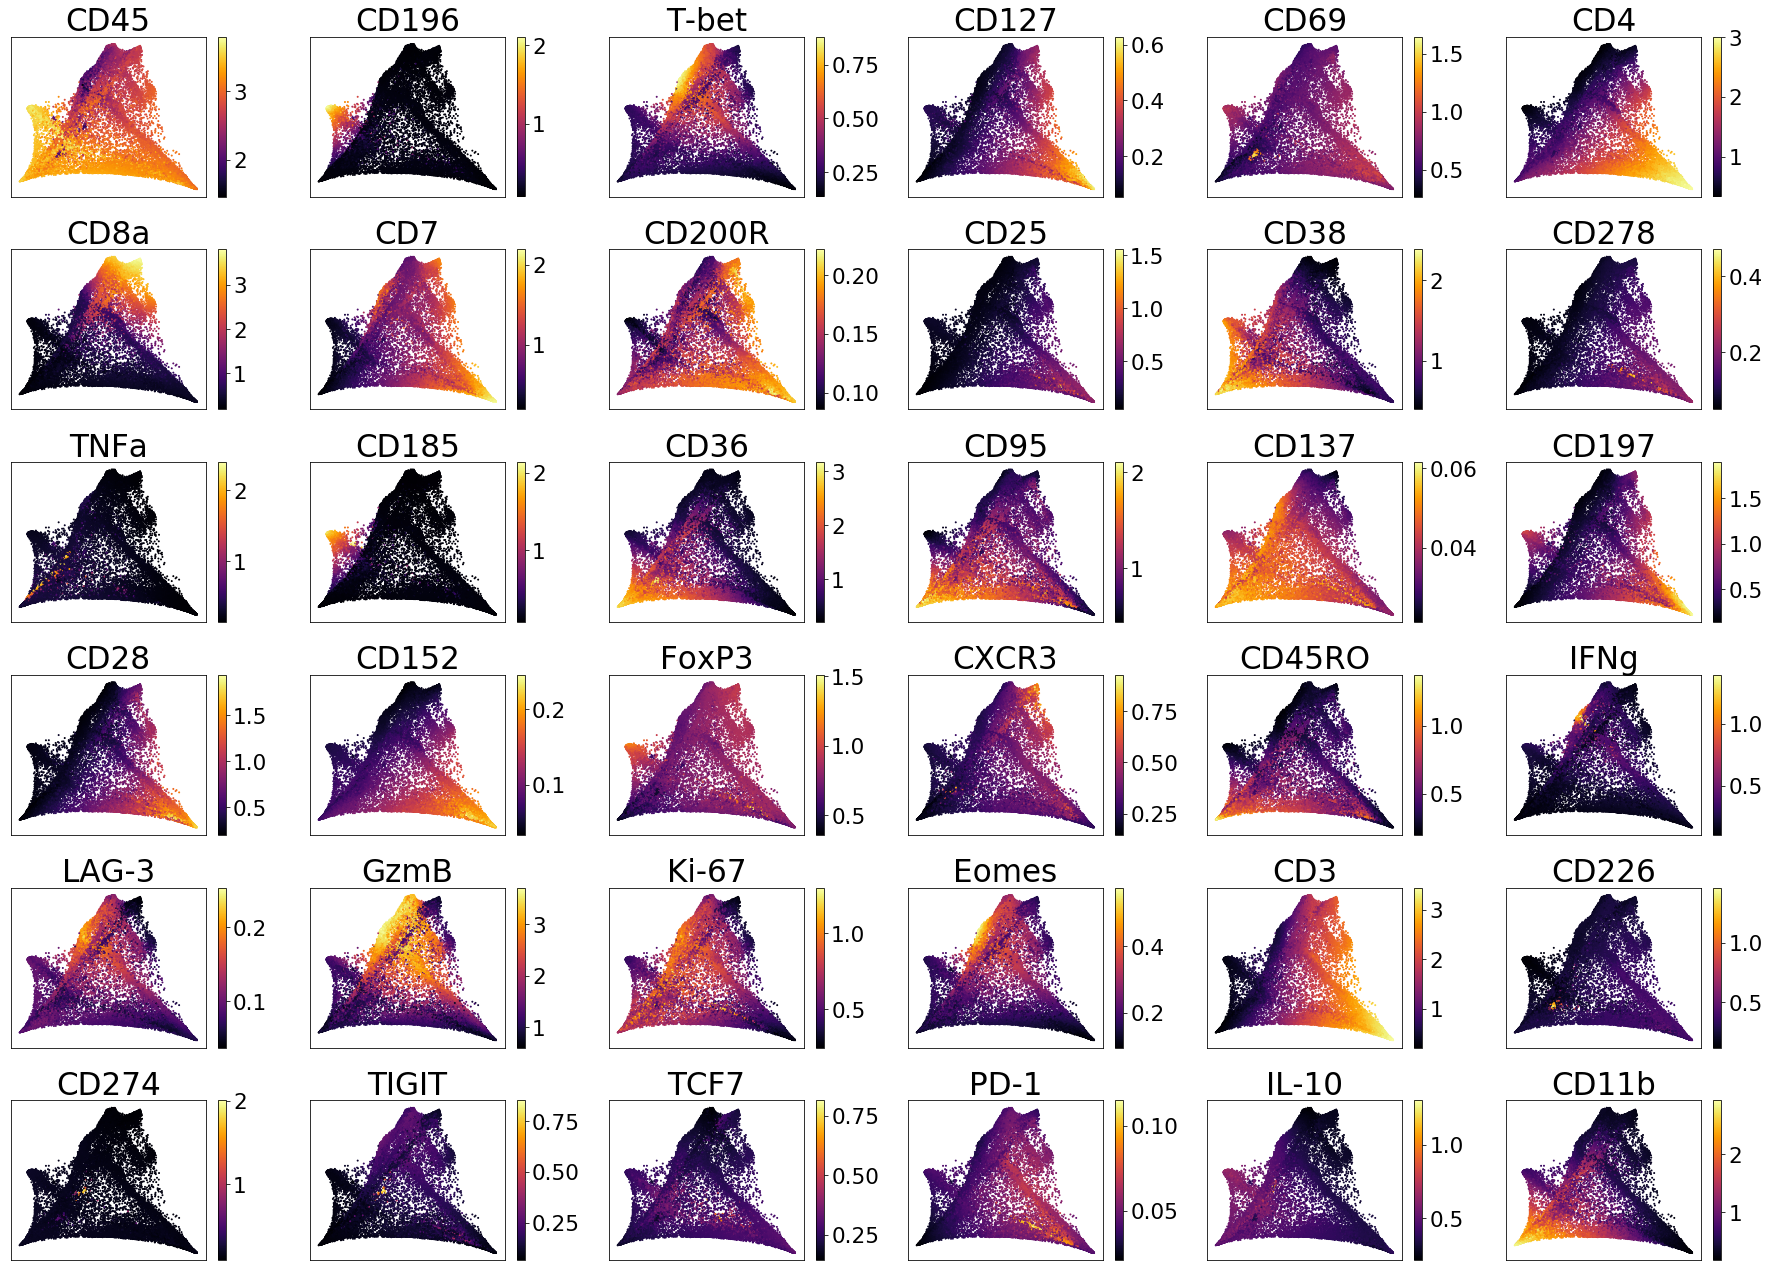

In [25]:
fig, axes = plt.subplots(6,6, figsize=(25,18))
axes = axes.flatten()
curr_mask = metadata['run'] == 1
for i, ax in enumerate(axes):
    if i >= len(data_magic.columns):
        ax.axis('off')
        continue
    curr_marker = data_magic.columns[i]
    curr_exp = data_magic[curr_marker]
    
    scprep.plot.scatter2d(data_phate[curr_mask], c=curr_exp[curr_mask], ax=ax, title=curr_marker, ticks=False,
                         cmap='inferno')
    
fig.tight_layout()
fig.savefig(os.path.join(fig_dir, 'PHATE.run1.all_markers.png'), dpi=300)

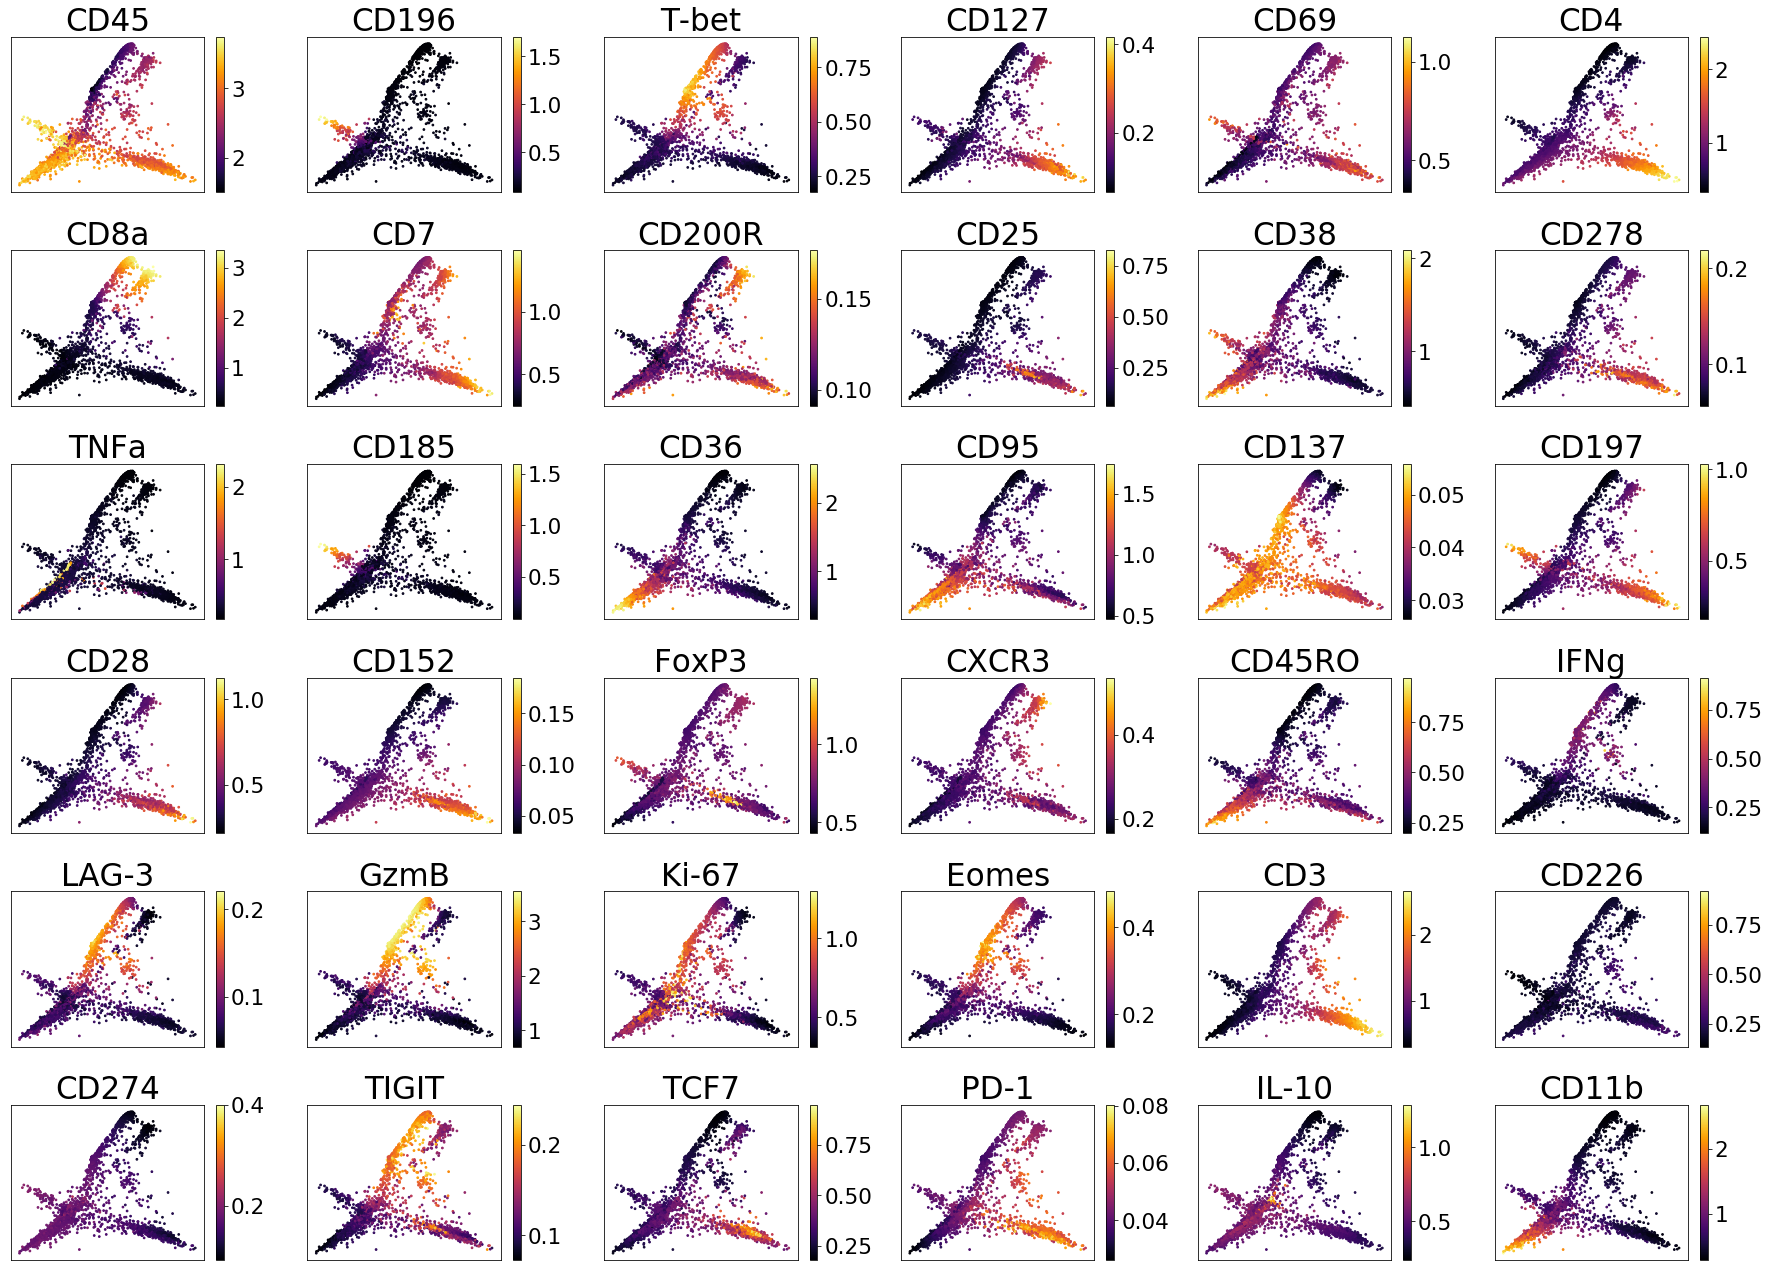

In [26]:
fig, axes = plt.subplots(6,6, figsize=(25,18))
axes = axes.flatten()
curr_mask = metadata['run'] == 2
for i, ax in enumerate(axes):
    if i >= len(data_magic.columns):
        ax.axis('off')
        continue
    curr_marker = data_magic.columns[i]
    curr_exp = data_magic[curr_marker]
    
    scprep.plot.scatter2d(data_phate[curr_mask], c=curr_exp[curr_mask], ax=ax, title=curr_marker, ticks=False)
    
fig.tight_layout()
fig.savefig(os.path.join(fig_dir, 'PHATE.run2.all_markers.png'), dpi=300)

In [27]:
G_run1 = gt.read_pickle('/home/dan/data/burkhardt/sbrt_trial/run1.pre_and_post.graph.pkl')

G_run2 = gt.read_pickle('/home/dan/data/burkhardt/sbrt_trial/run2.pre_and_post.graph.pkl')

In [37]:
meld_op = meld.MELD()
response_ees_run2 = meld_op.fit_transform(G=G_run2, RES=metadata['response_RES'][metadata['run'] == 2])
response_ees_run2 = response_ees_run2 - np.mean(response_ees_run2)

In [38]:
meld_op = meld.MELD()
response_ees_run1 = meld_op.fit_transform(G=G_run1, RES=metadata['response_RES'][metadata['run'] == 1])
response_ees_run1 = response_ees_run1-np.mean(response_ees_run1)

In [1]:
fig, axes = plt.subplots(1,2, figsize=(14,6))

for i, ax in enumerate(axes):
    if i == 0:
        curr_mask = metadata['run'] == 1
        curr_cvec = response_ees_run1
        title = 'Run 1 - Response EES'
        vmin = - np.max(np.abs(curr_cvec))
    elif i == 1:
        curr_mask = metadata['run'] == 2
        curr_cvec = response_ees_run2
        title = 'Run 2 - Response EES'
    vmin = -np.max(np.abs(curr_cvec))
    vmax = np.max(np.abs(curr_cvec))
    scprep.plot.scatter2d(data_phate[curr_mask], c=curr_cvec, cmap='RdBu_r',
                          vmin=vmin, vmax=vmax,
                     title=title, ticks=False, label_prefix='PHATE', ax=ax)
    
fig.tight_layout()

NameError: name 'plt' is not defined

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(14,6))

for i, ax in enumerate(axes):
    if i == 0:
        curr_mask = metadata['run'] == 1
        curr_cvec = response_ees_run1
        title = 'Run 1 only'
    elif i == 1:
        curr_mask = metadata['run'] == 2
        curr_cvec = response_ees_run2
        title = 'Run 2 only'
    
    scprep.plot.scatter2d(data_phate[curr_mask], c=curr_cvec, cmap='RdBu_r',
                     title=title, ticks=False, label_prefix='PHATE', ax=ax)
    
fig.tight_layout()